Best parameters: {'metric': 'euclidean', 'n_neighbors': 5}
MSE: 1060164570685.7142, R²: 0.5135272038464213, MAE: 638734.2857142857, RMSE: 1029642.9335870345


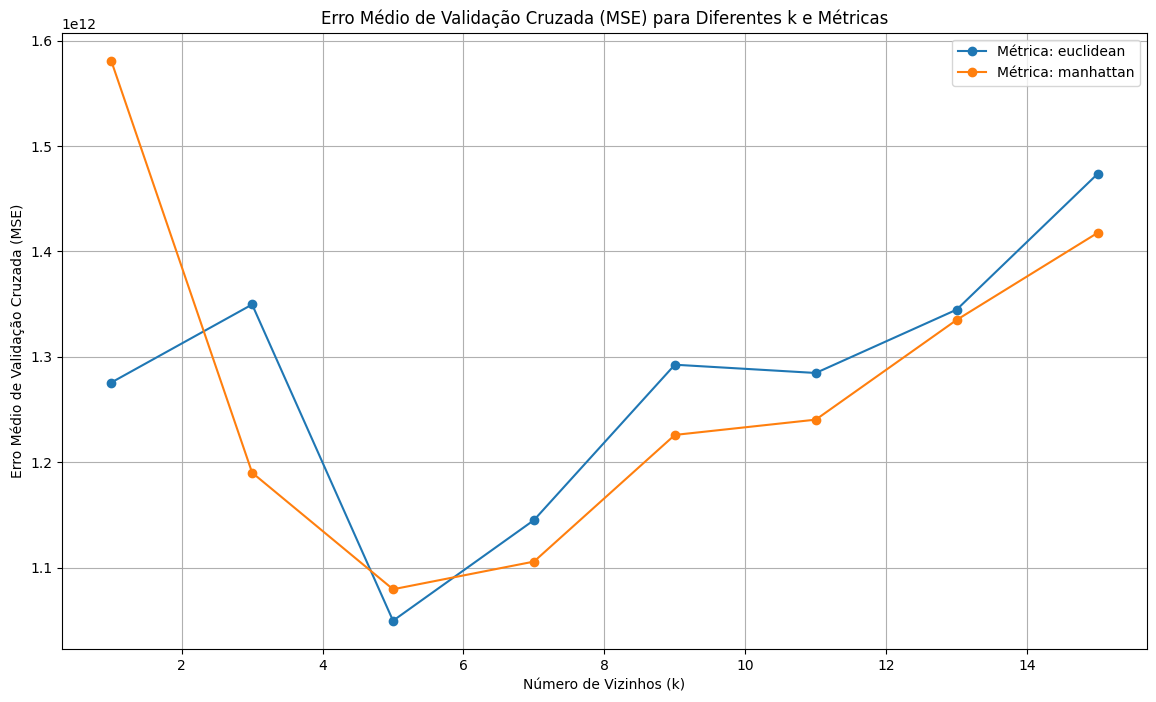

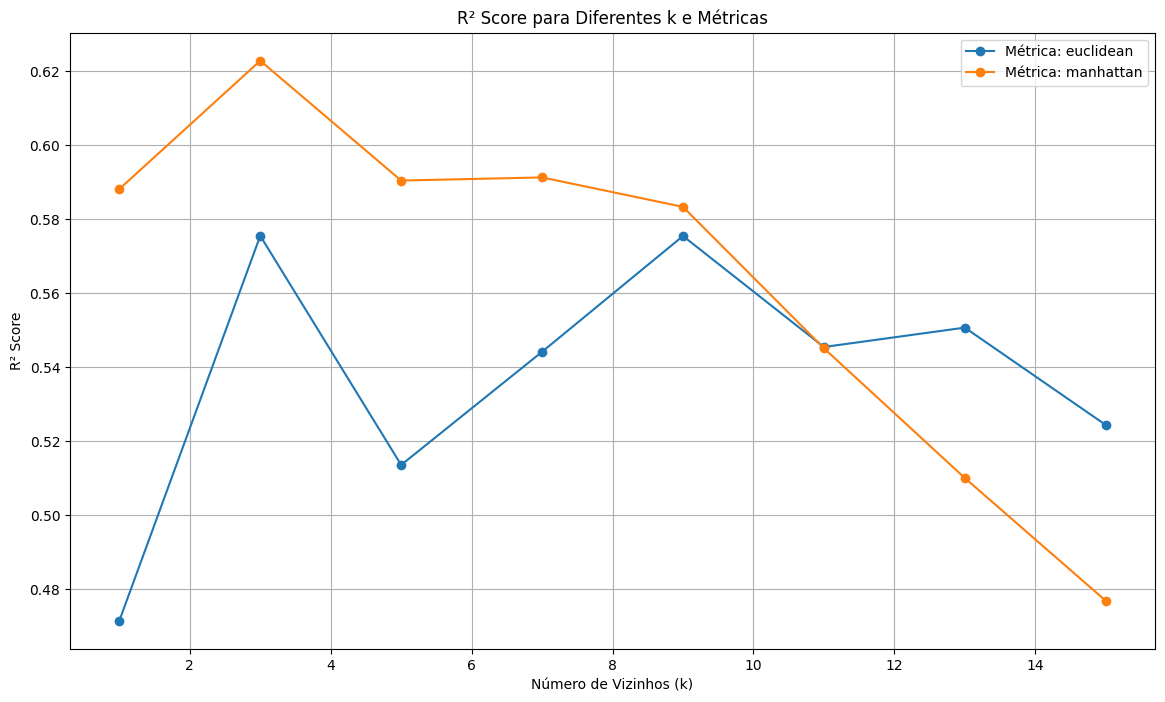

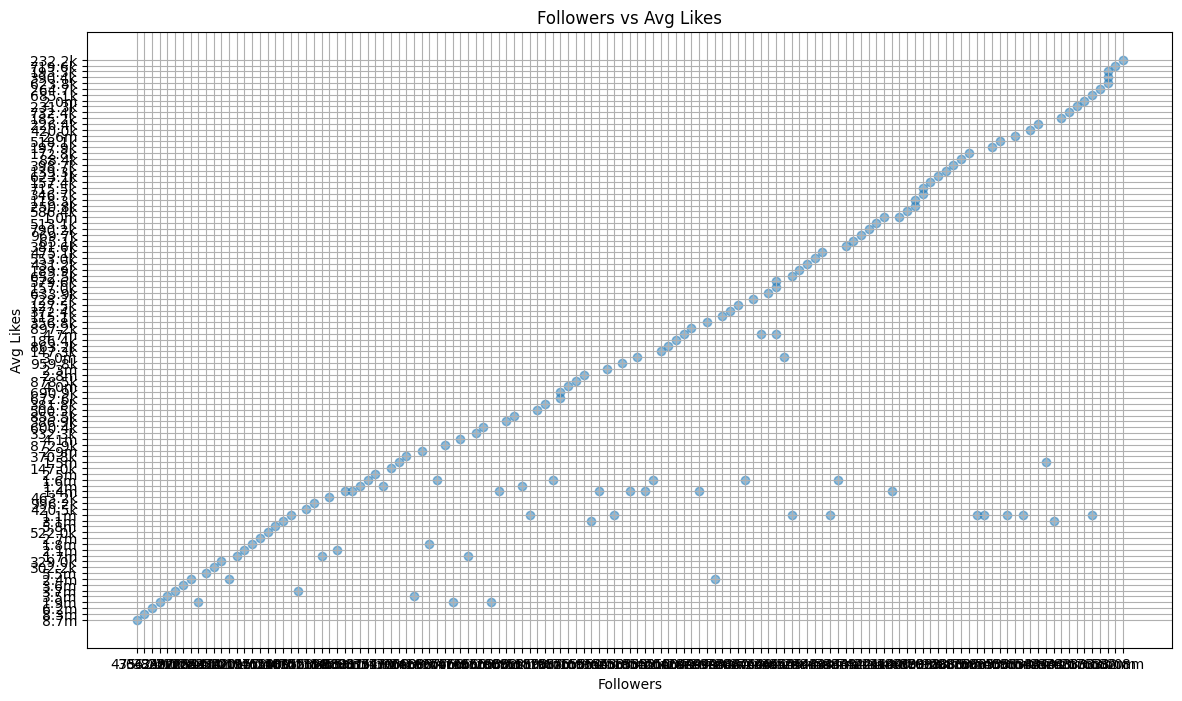

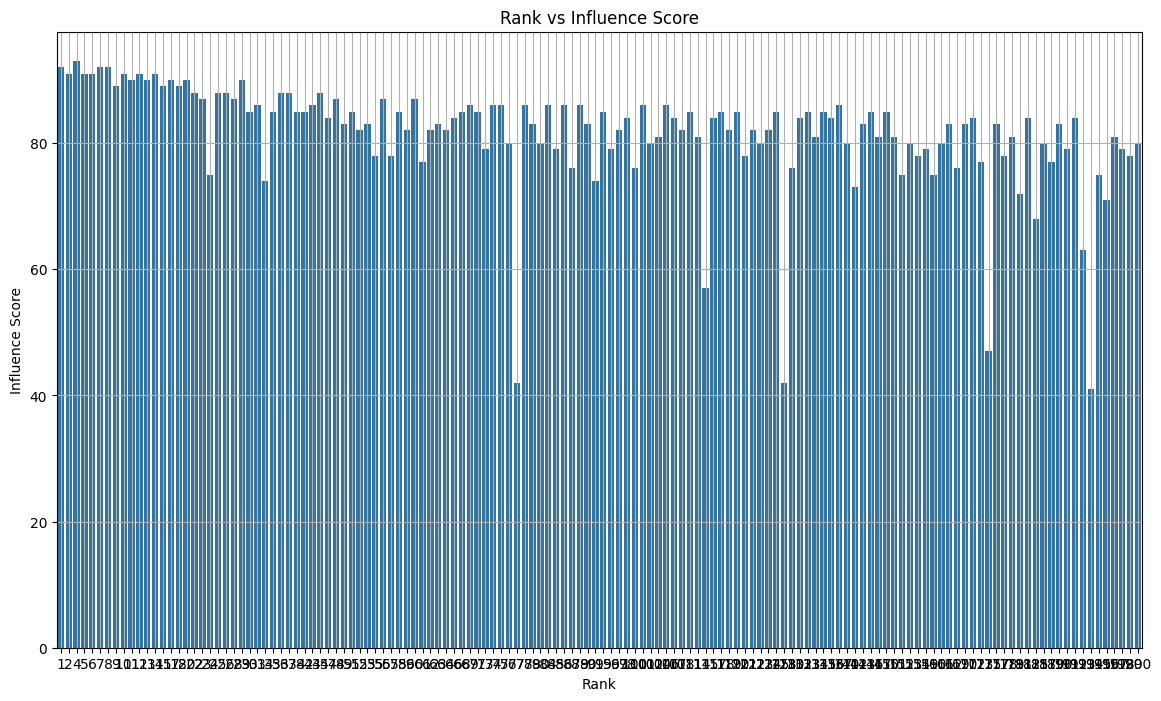

In [1]:
import pandas as pd
from country_code import country_to_code
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt


def main():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None) 

    influencers_data = pd.read_csv("top_insta_influencers_data.csv")

    # Dropar NaNs
    influencers_data.dropna(inplace=True)

    # Mapear países para códigos
    influencers_data['country'] = influencers_data['country'].map(country_to_code)

    X = influencers_data[['followers', '60_day_eng_rate']]
    y = influencers_data['avg_likes']

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train['followers'] = X_train['followers'].map(convert)
    X_train['60_day_eng_rate'] = X_train['60_day_eng_rate'].map(lambda x: float(x[:-1]))
    X_test['followers'] = X_test['followers'].map(convert)
    X_test['60_day_eng_rate'] = X_test['60_day_eng_rate'].map(lambda x: float(x[:-1]))
    y_train = y_train.map(convert)
    y_test = y_test.map(convert)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Otimização de Hiperparâmetros usando GridSearchCV
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15], 'metric': ['euclidean', 'manhattan']}
    grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)

    best_knn = grid_search.best_estimator_

    # Fazer previsões no conjunto de teste
    y_pred = best_knn.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"MSE: {mse}, R²: {r2}, MAE: {mae}, RMSE: {rmse}")

    # Testar diferentes valores de k e métricas de distância
    k_values = [1, 3, 5, 7, 9, 11, 13, 15]
    distances = ['euclidean', 'manhattan']
    results = []

    # Loop para testar várias combinações de k e métricas
    for distance in distances:
        for k in k_values:
            knn = KNeighborsRegressor(n_neighbors=k, metric=distance)
            knn.fit(X_train_scaled, y_train)
            
            # Validação cruzada com 5 folds
            cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
            mean_cv_score = -np.mean(cv_scores)  # Negativo porque a métrica MSE é negativa no scikit-learn

            # Fazer previsões no conjunto de teste
            y_pred = knn.predict(X_test_scaled)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            # Armazenar resultados
            results.append({
                'k': k,
                'distance_metric': distance,
                'mean_cv_mse': mean_cv_score,
                'test_mse': mse,
                'r2_score': r2
            })

    # Transformar os resultados em um DataFrame
    results_df = pd.DataFrame(results)

    # Plotar o erro de validação cruzada médio para cada k e métrica de distância
    plt.figure(figsize=(14, 8))
    for distance in distances:
        subset = results_df[results_df['distance_metric'] == distance]
        plt.plot(subset['k'], subset['mean_cv_mse'], label=f'Métrica: {distance}', marker='o')

    plt.title('Erro Médio de Validação Cruzada (MSE) para Diferentes k e Métricas')
    plt.xlabel('Número de Vizinhos (k)')
    plt.ylabel('Erro Médio de Validação Cruzada (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotar R² Score para cada k e métrica de distância
    plt.figure(figsize=(14, 8))
    for distance in distances:
        subset = results_df[results_df['distance_metric'] == distance]
        plt.plot(subset['k'], subset['r2_score'], label=f'Métrica: {distance}', marker='o')

    plt.title('R² Score para Diferentes k e Métricas')
    plt.xlabel('Número de Vizinhos (k)')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfico de dispersão de followers vs avg_likes
    plt.figure(figsize=(14, 8))
    plt.scatter(X['followers'], y, alpha=0.5)
    plt.title('Followers vs Avg Likes')
    plt.xlabel('Followers')
    plt.ylabel('Avg Likes')
    plt.grid(True)
    plt.show()

    # Gráfico de barras comparando rank com influence_score
    plt.figure(figsize=(14, 8))
    sns.barplot(x='rank', y='influence_score', data=influencers_data)
    plt.title('Rank vs Influence Score')
    plt.xlabel('Rank')
    plt.ylabel('Influence Score')
    plt.grid(True)
    plt.show()


def convert(x):
    if x[-1] == 'k':
        return float(x[:-1]) * 1e3
    elif x[-1] == 'm':
        return float(x[:-1]) * 1e6
    else:
        return float(x)


if __name__ == '__main__':
    main()